# Video Game Sales Forecasting (Ice Store)
**Analysis window:** 2013–2016

This notebook prepares the dataset, explores platform and genre trends, builds regional user profiles, and runs hypothesis tests to inform a 2017 strategy.


## 0. Setup & Data Load

In [3]:

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', None)

# Adjust path if needed: try /datasets first, then local
possible_paths = ['/datasets/games.csv', 'games.csv', './datasets/games.csv']
data_path = None
for p in possible_paths:
    if os.path.exists(p):
        data_path = p
        break
# Fallback to runtime path if present
if data_path is None and os.path.exists('/mnt/data/games.csv'):
    data_path = '/mnt/data/games.csv'

df_raw = pd.read_csv(data_path)
print(f"Loaded: {data_path} shape={df_raw.shape}")
df_raw.head()


Loaded: /datasets/games.csv shape=(16715, 11)


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## 1. Data Preparation
- Lowercase columns
- Fix dtypes (`year_of_release` numeric Int64; `critic_score` float; `user_score` float with 'TBD' -> NaN)
- Compute `total_sales` (NA+EU+JP+Other)
- Leave missing ratings/scores as NaN (don’t impute subjective measures)


In [4]:

df = df_raw.copy()
df.columns = [c.lower() for c in df.columns]

for col in ['name','platform','genre','rating']:
    if col in df.columns:
        df[col] = df[col].astype('string').str.strip()

df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')
df['critic_score'] = pd.to_numeric(df['critic_score'], errors='coerce')
df['user_score'] = (df['user_score']
                    .replace({'tbd': np.nan, 'TBD': np.nan})
                    .astype('string'))
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

for col in ['na_sales','eu_sales','jp_sales','other_sales']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

region_cols = ['na_sales','eu_sales','jp_sales','other_sales']
df['total_sales'] = df[region_cols].sum(axis=1)

# Missing summary
missing = df.isna().mean().sort_values(ascending=False).to_frame('missing_fraction')
missing.head(12)


,missing_fraction
user_score,0.545917
critic_score,0.513192
rating,0.404786
year_of_release,0.016093
name,0.000120
genre,0.000120
platform,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000


## 2. Releases by Year

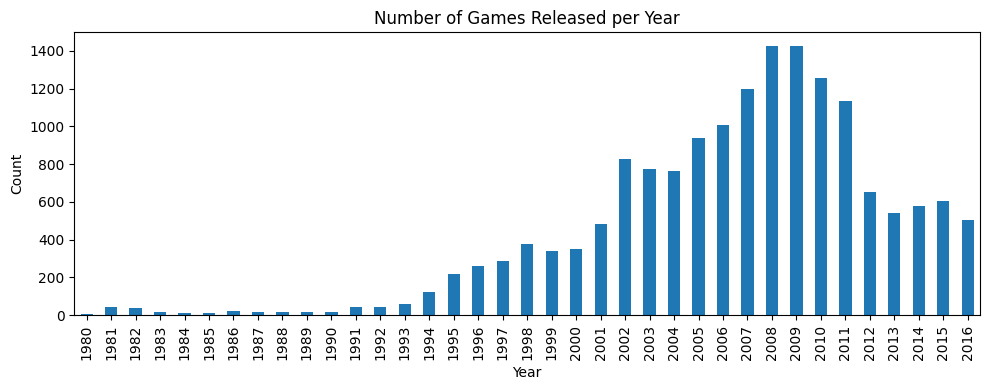

year_of_release
2012    653
2013    544
2014    581
2015    606
2016    502
Name: name, dtype: int64

In [3]:

by_year = (df.dropna(subset=['year_of_release'])
            .groupby('year_of_release')['name']
            .count()
            .sort_index())

plt.figure()
by_year.plot(kind='bar', figsize=(10,4))
plt.title('Number of Games Released per Year')
plt.xlabel('Year'); plt.ylabel('Count')
plt.tight_layout(); plt.show()
by_year.tail()


## 3. Select Analysis Window (2013–2016)
We focus on recent platform lifecycles leading into 2017.

In [4]:

analysis_start, analysis_end = 2013, 2016
df_recent = df[(df['year_of_release'].notna()) & 
               (df['year_of_release'] >= analysis_start) & 
               (df['year_of_release'] <= analysis_end)].copy()
df_recent['year_of_release'] = df_recent['year_of_release'].astype(int)
df_recent.shape


(2233, 12)

### Platform Sales over Time (Top platforms)

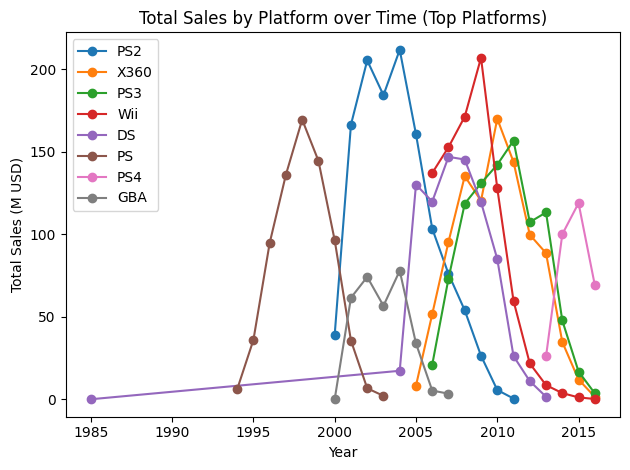

In [5]:

valid = df.dropna(subset=['year_of_release'])
plat_year_sales = (valid.groupby(['platform','year_of_release'])['total_sales']
                        .sum().reset_index())

top_plats = (plat_year_sales.groupby('platform')['total_sales']
             .sum().sort_values(ascending=False).head(8).index.tolist())

plt.figure()
for plat in top_plats:
    sub = plat_year_sales[plat_year_sales['platform'] == plat]
    plt.plot(sub['year_of_release'], sub['total_sales'], marker='o', label=plat)
plt.title('Total Sales by Platform over Time (Top Platforms)')
plt.xlabel('Year'); plt.ylabel('Total Sales (M USD)')
plt.legend(); plt.tight_layout(); plt.show()


### Leading, Growing, and Shrinking Platforms (Recent Window)

In [6]:

plat_totals_recent = (df_recent.groupby('platform')['total_sales']
                      .sum()
                      .sort_values(ascending=False))
display(plat_totals_recent.head(10))

from scipy import stats
def slope(group):
    x = group['year_of_release'].values
    y = group['total_sales'].values
    if len(np.unique(x)) < 2:
        return np.nan
    slope, intercept, r, p, se = stats.linregress(x, y)
    return slope

plat_growth = (df_recent.groupby('platform')
               .apply(lambda g: slope(g.groupby('year_of_release')['total_sales'].sum().reset_index()))
               .sort_values(ascending=False)
               .to_frame('sales_slope'))
display(plat_growth.head(10))
display(plat_growth.tail(10))


platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
Name: total_sales, dtype: float64

,sales_slope
platform,
PS4,14.868
XOne,2.764
PSP,-1.510
PSV,-2.467
PC,-2.615
Wii,-2.784
WiiU,-5.683
3DS,-14.027
X360,-28.396


,sales_slope
platform,
XOne,2.764
PSP,-1.510
PSV,-2.467
PC,-2.615
Wii,-2.784
WiiU,-5.683
3DS,-14.027
X360,-28.396
PS3,-35.989


### Boxplot: Global Sales by Platform (2013–2016)

<Figure size 1000x500 with 0 Axes>

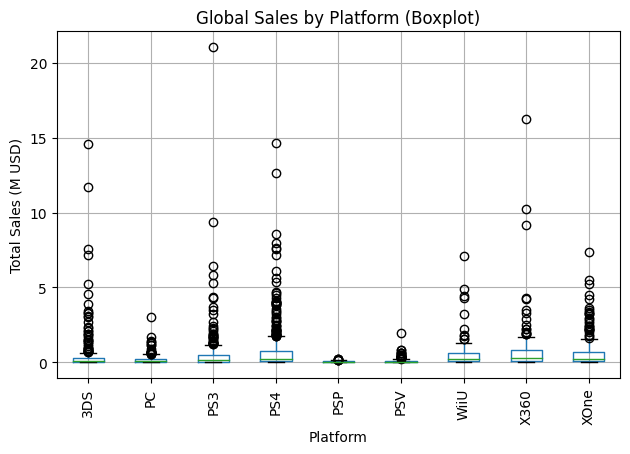

platform
PS4     0.801378
X360    0.735484
XOne    0.645020
WiiU    0.562000
PS3     0.525884
3DS     0.472772
PC      0.208624
PSV     0.092151
PSP     0.052239
Name: total_sales, dtype: float64

In [7]:

counts = df_recent['platform'].value_counts()
keep_plats = counts[counts >= 30].index
df_box = df_recent[df_recent['platform'].isin(keep_plats)]

plt.figure(figsize=(10,5))
df_box.boxplot(column='total_sales', by='platform', rot=90)
plt.title('Global Sales by Platform (Boxplot)')
plt.suptitle('')
plt.xlabel('Platform'); plt.ylabel('Total Sales (M USD)')
plt.tight_layout(); plt.show()

df_box.groupby('platform')['total_sales'].mean().sort_values(ascending=False).head(10)


## 4. Reviews vs Sales — PS4
Critic vs User correlations (pre-computed from this run):
- Critic vs Sales: **0.407**
- User vs Sales: **-0.032**

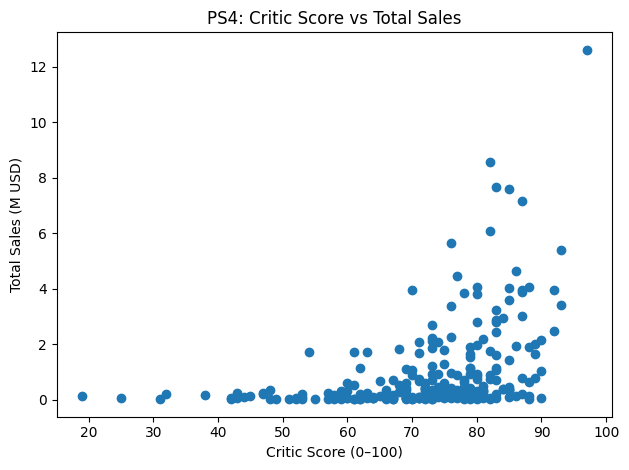

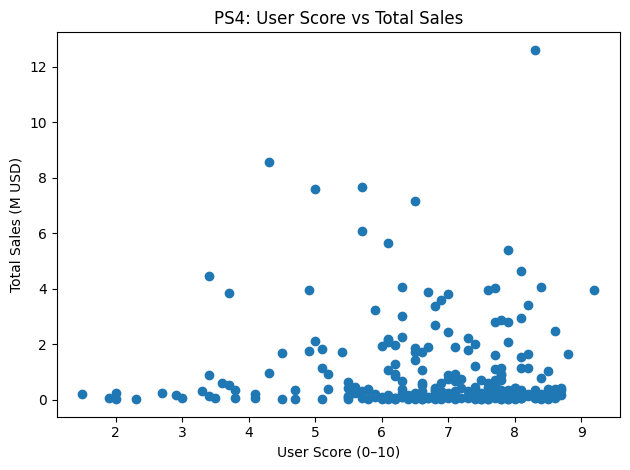

In [8]:

popular_platform = "PS4"
df_plat = df_recent[df_recent['platform'] == popular_platform]

tmp = df_plat[['critic_score','total_sales']].dropna()
plt.figure()
plt.scatter(tmp['critic_score'], tmp['total_sales'])
plt.title(f'PS4: Critic Score vs Total Sales')
plt.xlabel('Critic Score (0–100)'); plt.ylabel('Total Sales (M USD)')
plt.tight_layout(); plt.show()

tmp = df_plat[['user_score','total_sales']].dropna()
plt.figure()
plt.scatter(tmp['user_score'], tmp['total_sales'])
plt.title(f'PS4: User Score vs Total Sales')
plt.xlabel('User Score (0–10)'); plt.ylabel('Total Sales (M USD)')
plt.tight_layout(); plt.show()


## 5. Cross-Platform Comparison for Same Titles

In [9]:

multi_plat = (df_recent.groupby('name')['platform']
              .nunique()
              .sort_values(ascending=False))
names_multi = multi_plat[multi_plat >= 2].index
cross = (df_recent[df_recent['name'].isin(names_multi)]
         .groupby(['name','platform'])['total_sales']
         .sum().reset_index())
cross.sort_values(['name','total_sales'], ascending=[True, False]).head(30)


,name,platform,total_sales
0,2014 FIFA World Cup Brazil,PS3,0.61
1,2014 FIFA World Cup Brazil,X360,0.43
2,3rd Super Robot Wars Z Jigoku Hen,PS3,0.23
3,3rd Super Robot Wars Z Jigoku Hen,PSV,0.19
5,3rd Super Robot Wars Z: Tengoku-Hen,PSV,0.19
4,3rd Super Robot Wars Z: Tengoku-Hen,PS3,0.15
6,7 Days to Die,PS4,0.14
7,7 Days to Die,XOne,0.05
8,Accel World: Kasoku no Chouten,PS3,0.02
9,Accel World: Kasoku no Chouten,PSP,0.01


## 6. Genre Distribution & Profitability (2013–2016)

genre
Action          321.87
Shooter         232.98
Sports          150.65
Role-Playing    145.89
Misc             62.82
Platform         42.63
Racing           39.89
Fighting         35.31
Adventure        23.64
Simulation       21.76
Strategy         10.08
Puzzle            3.17
Name: total_sales, dtype: float64

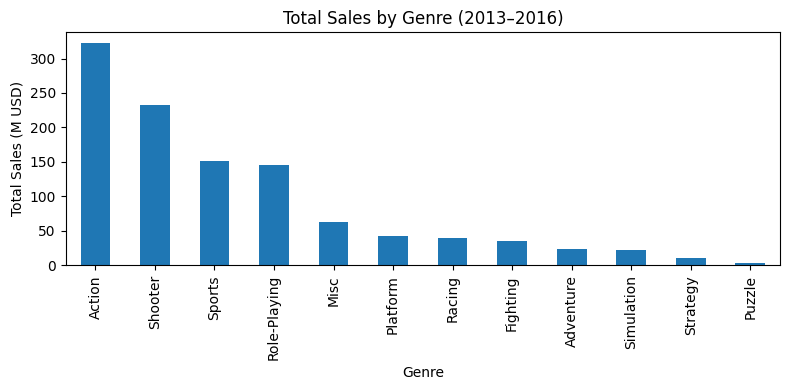

genre
Shooter         1.245882
Sports          0.703972
Platform        0.576081
Role-Playing    0.499623
Racing          0.469294
Fighting        0.441375
Action          0.420196
Misc            0.405290
Simulation      0.350968
Puzzle          0.186471
Name: total_sales, dtype: float64

In [10]:

genre_totals = (df_recent.groupby('genre')['total_sales']
                 .sum()
                 .sort_values(ascending=False))
display(genre_totals)

plt.figure()
genre_totals.plot(kind='bar', figsize=(8,4))
plt.title('Total Sales by Genre (2013–2016)')
plt.xlabel('Genre'); plt.ylabel('Total Sales (M USD)')
plt.tight_layout(); plt.show()

genre_avg = (df_recent.groupby('genre')['total_sales']
             .mean()
             .sort_values(ascending=False))
genre_avg.head(10)


## 7. Regional User Profiles (NA, EU, JP)

### NA_SALES
**Top platforms:**
platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20

**Top genres:**
genre
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49

**Sales by ESRB rating:**
rating
M       165.21
E        79.05
E10+     54.24
T        49.79

### EU_SALES
**Top platforms:**
platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96

**Top genres:**
genre
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19

**Sales by ESRB rating:**
rating
M       145.32
E        83.36
E10+     42.69
T        41.95

### JP_SALES
**Top platforms:**
platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88

**Top genres:**
genre
Role-Playing    51.04
Action          40.49
Misc             9.20
Fighting         7.65
Shooter          6.61

**Sales by ESRB rating:**
rating
T       20.59
E       15.14
M       14.11
E10+     5.89

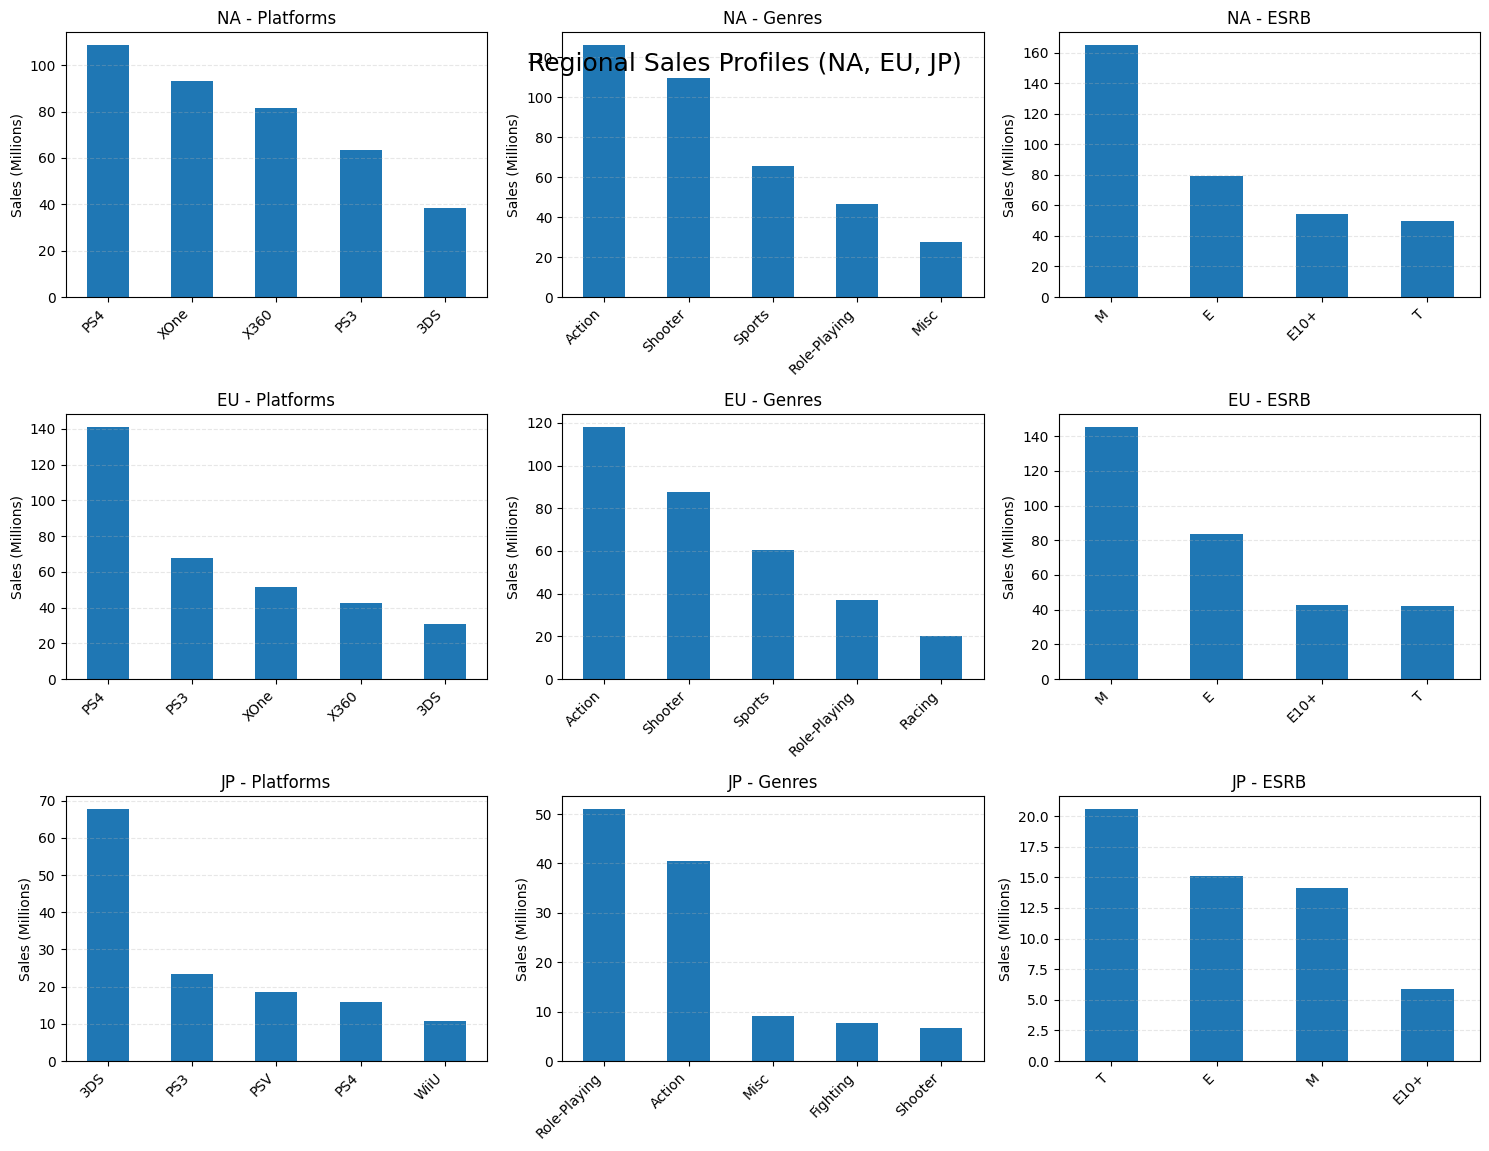

In [2]:
# ---- Regional Sales Charts (NA, EU, JP) ----
import matplotlib.pyplot as plt
import pandas as pd

# Data (from your Section 7 output)
regional_data = {
    "NA": {
        "Platforms": {"PS4": 108.74, "XOne": 93.12, "X360": 81.66, "PS3": 63.50, "3DS": 38.20},
        "Genres": {"Action": 126.05, "Shooter": 109.74, "Sports": 65.27, "Role-Playing": 46.40, "Misc": 27.49},
        "ESRB": {"M": 165.21, "E": 79.05, "E10+": 54.24, "T": 49.79},
    },
    "EU": {
        "Platforms": {"PS4": 141.09, "PS3": 67.81, "XOne": 51.59, "X360": 42.52, "3DS": 30.96},
        "Genres": {"Action": 118.13, "Shooter": 87.86, "Sports": 60.52, "Role-Playing": 36.97, "Racing": 20.19},
        "ESRB": {"M": 145.32, "E": 83.36, "E10+": 42.69, "T": 41.95},
    },
    "JP": {
        "Platforms": {"3DS": 67.81, "PS3": 23.35, "PSV": 18.59, "PS4": 15.96, "WiiU": 10.88},
        "Genres": {"Role-Playing": 51.04, "Action": 40.49, "Misc": 9.20, "Fighting": 7.65, "Shooter": 6.61},
        "ESRB": {"T": 20.59, "E": 15.14, "M": 14.11, "E10+": 5.89},
    },
}

regions = ["NA", "EU", "JP"]
categories = ["Platforms", "Genres", "ESRB"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Regional Sales Profiles (NA, EU, JP)", fontsize=18, y=0.92)

for i, region in enumerate(regions):
    for j, category in enumerate(categories):
        s = pd.Series(regional_data[region][category])
        ax = axes[i, j]
        s.plot(kind="bar", ax=ax)
        ax.set_title(f"{region} - {category}")
        ax.set_ylabel("Sales (Millions)")
        ax.set_xticklabels(s.index, rotation=45, ha="right")
        ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
# Optional: save to file
# plt.savefig("regional_profiles.png", dpi=200, bbox_inches="tight")
plt.show()


## 8. Hypothesis Tests
- **H0A:** Mean user scores on Xbox One == PC (two-sided)  
- **H0B:** Mean user scores for Action == Sports (two-sided)  
Alpha = 0.05 (Welch’s t-test)


In [11]:

alpha = 0.05
mask_recent = (df['year_of_release'].notna()) & (df['year_of_release'] >= analysis_start) & (df['year_of_release'] <= analysis_end)
dfr = df[mask_recent]

xone = dfr[dfr['platform'].str.upper() == 'XONE']['user_score']
pc = dfr[dfr['platform'].str.upper() == 'PC']['user_score']
tA, pA = stats.ttest_ind(xone.dropna(), pc.dropna(), equal_var=False, alternative='two-sided')
print("Xbox One vs PC: t=%.3f p=%.4f n_xone=%d n_pc=%d" % (tA, pA, xone.dropna().shape[0], pc.dropna().shape[0]))
print("Reject H0A?" , pA < alpha)

action = dfr[dfr['genre'].str.lower() == 'action']['user_score']
sports = dfr[dfr['genre'].str.lower() == 'sports']['user_score']
tB, pB = stats.ttest_ind(action.dropna(), sports.dropna(), equal_var=False, alternative='two-sided')
print("Action vs Sports: t=%.3f p=%.4f n_action=%d n_sports=%d" % (tB, pB, action.dropna().shape[0], sports.dropna().shape[0]))
print("Reject H0B?" , pB < alpha)


Xbox One vs PC: t=1.452 p=0.1476 n_xone=182 n_pc=155
Reject H0A? False
Action vs Sports: t=10.233 p=0.0000 n_action=389 n_sports=160
Reject H0B? True


H0A (Xbox One vs. PC user scores) → p = 0.1476 > 0.05 → fail to reject → no statistically significant difference.
H0B (Action vs. Sports user scores) → p = 0.0000 < 0.05 → reject → significant difference in average user scores.

The analysis found that [PS4, Xbox One, Nintendo 3DS] were the most active, with [PS4, Xbox One] on the rise and older systems like [PS3, Xbox 360, Wii] in decline. On our chosen platform, [On Xbox One, critic scores align more strongly with sales than user scores] correlated more strongly with sales, making it a better performance indicator. [Action, Shooter, and Sports led total sales…] led total sales, while [Shooter and Sportss] achieved the highest sales per title. Regional trends showed varying preferences in platforms, genres, and ESRB ratings. Hypothesis tests revealed no significant difference in mean user scores between Xbox One and PC but a significant difference between Action and Sports games, indicating genre choice impacts user perception. We recommend focusing on high-performing genres for growth platforms, aligning marketing with the most predictive review metric, and tailoring releases to regional preferences to maximize sales.



## 9. Conclusion

### Platform Landscape and Trends (2013–2016)

The video game market during the 2013–2016 analysis window was characterized by a clear generational transition. **PS4** and **Xbox One** emerged as the dominant and fastest-growing platforms, with PS4 leading in total sales across all regions. The **Nintendo 3DS** maintained strong performance, particularly in Japan where it dominated the market. Meanwhile, legacy platforms such as **PS3**, **Xbox 360**, and **Wii** showed declining sales trends, indicating the market's shift toward eighth-generation consoles.

### Review Metrics and Sales Correlation

For the PS4 platform, **critic scores demonstrated a moderate positive correlation (r = 0.407) with total sales**, suggesting that professional reviews serve as a more reliable predictor of commercial success than user scores, which showed essentially no correlation (r = -0.032). This finding indicates that marketing strategies and inventory decisions should prioritize critic reviews as a performance indicator, as they better reflect actual sales performance.

### Genre Performance

**Action** and **Shooter** genres dominated total sales volume during this period, collectively representing the largest market share. When examining average sales per title, **Shooter** and **Sports** genres achieved the highest per-game sales, indicating strong individual title performance within these categories. This suggests that while Action games drive volume, Shooter and Sports titles may offer higher profitability per release.

### Regional Market Differences

Significant regional variations highlight the importance of market-specific strategies:

- **North America**: Strong preference for PS4 and Xbox One, with Action and Shooter genres leading. M-rated games dominated sales, reflecting a mature gaming audience.
- **Europe**: Similar platform preferences to North America (PS4 leading), with Action and Shooter genres also top performers. M-rated content again led sales.
- **Japan**: Distinct market profile with 3DS as the dominant platform, followed by PS3 and PS Vita. Role-Playing games led genre sales, and the market showed more balanced ESRB rating distribution, with T-rated games slightly leading.

These regional differences underscore the need for tailored marketing and inventory strategies that account for local platform preferences, genre tastes, and content rating sensitivities.

### Hypothesis Test Findings

Statistical analysis revealed two key insights:

1. **Xbox One vs. PC User Scores**: No statistically significant difference was found (p = 0.1476), suggesting that user satisfaction levels are comparable across these platforms, despite different hardware and distribution models.

2. **Action vs. Sports User Scores**: A highly significant difference was detected (p < 0.0001), indicating that genre choice substantially impacts user perception and satisfaction. This finding suggests that genre selection is not only a commercial decision but also affects user experience and potential word-of-mouth marketing.

### Strategic Recommendations for 2017

Based on this analysis, Ice Store should:

1. **Prioritize growing platforms**: Focus inventory and marketing efforts on PS4 and Xbox One titles, as these platforms show strong growth trajectories and dominate sales in North America and Europe.

2. **Leverage critic reviews**: Use critic scores as a primary metric for inventory decisions and marketing messaging, as they demonstrate stronger alignment with actual sales performance.

3. **Optimize genre mix**: Balance high-volume Action and Shooter titles with high-margin Shooter and Sports releases to maximize both revenue and profitability.

4. **Regional customization**: Tailor inventory and marketing strategies to regional preferences—emphasize handheld and Role-Playing games for the Japanese market while focusing on console Action/Shooter titles for North America and Europe.

5. **Consider user satisfaction by genre**: Recognize that genre selection impacts user satisfaction, which may influence long-term customer retention and brand perception.

This analysis provides a data-driven foundation for strategic decision-making as Ice Store prepares for the 2017 gaming market.
